error: 1.6089087782543754


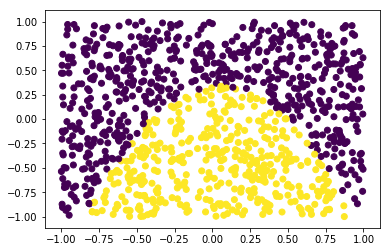

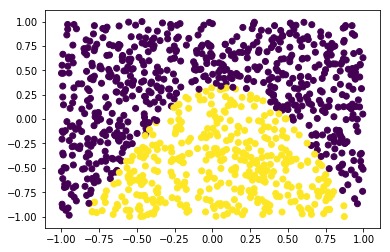

In [50]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors



def deriv_sigmoid(x):
    output=x*(1-x)
    return output

def deriv_tanh(x):
    output = 1-x*x
    return output

def reLU(x):
    output = torch.max(x, torch.Tensor(x.size(0), x.size(1)).fill_(0))
    return output

#This was completely wrong in the previous version!
def deriv_reLU(x):
    p = torch.max(x, torch.Tensor(x.size(0), x.size(1)).fill_(0))
    q = torch.ceil(p)
    output = torch.min(q, torch.Tensor(x.size(0), x.size(1)).fill_(1))
    return output

#initialize training set
data = torch.Tensor(np.fromfile('./training_data_X', sep=" "))
trainingX = data.view(-1,2)
data = torch.Tensor(np.fromfile('./training_data_T', sep=" "))
trainingT = data.view(-1,1)

#initialize test set
test = torch.Tensor(np.fromfile('./test_data_X', sep=" "))
testX = test.view(-1,2)
test = torch.Tensor(np.fromfile('./test_data_T', sep=" "))
testT = test.view(-1,1)

#initialize the parameters
#nbn is a variable. Its value is the number of neurons in the hidden layer
set_size = trainingX.size(0) #1024
nbn = 15
l_r = 0.0001

W0 = torch.Tensor(2*np.random.random((2,nbn)) -1)
W1 = torch.Tensor(2*np.random.random((nbn,1)) -1) 
B1 = torch.Tensor(2*np.random.random((nbn,1)) -1)
B2 = torch.Tensor(2*np.random.random((1,1)) -1)
layer_0 = trainingX
for iter in range(5000):
    
    #forward equations
    #first layer: tanh function
   
    layer_1 = torch.tanh(torch.matmul(layer_0,W0)+(torch.t(B1)).expand(set_size,nbn))
    #layer 2: reLU function
    layer_2 = reLU(torch.matmul(layer_1,W1)+(torch.t(B2)).expand(set_size,1))
    
   
    #backprop 1st step
    l2_err_deriv = trainingT - layer_2
    l2_delta = l2_err_deriv*deriv_reLU(layer_2)
    W1 += l_r*torch.matmul(torch.t(layer_1), l2_delta) #learning rate != 1
    B2 += l_r*torch.sum(l2_delta)
   
    #backprop 2nd step
    l1_err_deriv = torch.matmul(l2_delta, torch.t(W1))
    
    
    l1_delta = l1_err_deriv*deriv_tanh(layer_1)
    W0 += l_r*torch.matmul(torch.t(layer_0), l1_delta)
    B1 += l_r*torch.t(torch.sum(l1_delta,0,True))
    #

#test phase
#forward equations with new coefficients
layer_0test = testX
layer_1test = torch.tanh(torch.matmul(layer_0test,W0)+(torch.t(B1)).expand(set_size,nbn))

#layer 2
layer_2test = reLU(torch.matmul(layer_1test,W1)+(torch.t(B2)).expand(set_size,1)) #rounded values for error calculations
error = torch.sum((testT-layer_2test)*(testT-layer_2test))*50/set_size
print('error:', error)
#print(layer_2)

plt.figure(1)
plt.scatter(testX[:,0],testX[:,1],c=testT.view(1024))
plt.figure(2)

plt.scatter(testX[:,0],testX[:,1], c=torch.round(layer_2test.view(1024)))